In [51]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import os
from PIL import Image

from shutil import copyfile
import base64
from io import BytesIO
from IPython.display import HTML
import pickle
import imutils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Activation
from keras.layers import Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model

from mtcnn.mtcnn import MTCNN
# print version

import cv2
import copy

from tqdm import tqdm
import glob

Using TensorFlow backend.


In [24]:
class Image():
    
    def __init__(self, image, landmarks, name):
        # self.image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.image = image
        self.original_image = copy.deepcopy(self.image)
        self.landmarks = landmarks
        self.name = name
        self.neutralised_image = np.array([])
        self.hash = hash(self)
    
    def setNeutralisedImage(self, image):
        self.neutralised_image = image
        
    def getNeutralisedImage(self):
        return self.neutralised_image
        
    def getName(self):
        return self.name
        
    def getImage(self):
        return self.image
    
    def clearImage(self):
        self.image= copy.deepcopy(self.original_image)
        return self.image
    
    def getLandmarks(self):
        return self.landmarks
    
    def getHash(self):
        return self.hash

In [25]:
def getLandmarksForImage(imagePath):
    cur_landmark = "\\".join(str(imagePath).rsplit('\\',3)[-3:])[:-4]
    landmark_path = ck_landmarks_path + '\\' + cur_landmark + '_landmarks.txt'
    landmarks = np.loadtxt(landmark_path)
    return landmarks


def view_landmarks(landmarks, color='r'):
    xs, ys = list(zip(*landmarks))
    plt.scatter(xs, ys, color=color)
    return 

In [26]:
base_path = "..\\Data"

In [27]:
ck_data_path = base_path + '\\CK+\\cohn-kanade-images'
ck_landmarks_path = base_path + '\\CK+\\Landmarks'
ck_image_files = glob.glob(ck_data_path+'/**/*.png', recursive=True)

ck_image_files = ck_image_files[7000:]

In [28]:
len(ck_image_files)

3708

In [29]:
face_det = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
face_det2 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt2.xml")
face_det3 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt.xml")
face_det4 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt_tree.xml")

def detect_face(f, ld):
    ''' function to detect face, crop the image and resize it and resize the corresponding landmarks too '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
#     ld = np.array([np.array(i) for i in ld])
    crop_ld = ld
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        fw, fh = w, h
        if any(ld[:,0] > x+w):
            fw = int(max(ld[:,0]-x))
        if any(ld[:,1] > y+h):
            fh = int(max(ld[:,1]-y))
#         gray = gray[y:y+h, x:x+w] #Cut the frame to size
        gray = gray[y:y+fh+5, x:x+fw+5] #Cut the frame to size to max of landmark with padding of 5px
        ld_rescale_factor = (gray.shape[1]/crop_imsize, (gray.shape[0]/crop_imsize))
        crop_ld = np.array(list(zip(ld[:,0]-x, ld[:, 1]-y)))
    try:
        output = cv2.resize(gray, (crop_imsize, crop_imsize))
        crop_ld = crop_ld/ld_rescale_factor
        cv2.imwrite(crop_path+'/crop_'+f.split('/')[-1], output)
    except:
        output = gray

    return output, crop_ld

In [30]:
images = []
crop_imsize = 160

with tqdm(total=len(ck_image_files), desc="Processing entries") as pbar:
    for i, ck_image in enumerate(ck_image_files):
        

        landmarks = getLandmarksForImage(ck_image)
        image, landmarks = detect_face(ck_image, landmarks)
        image = cv2.resize(image,(crop_imsize, crop_imsize))
        images.append(Image(image, landmarks, ck_image))
        
        pbar.update(1)

Processing entries: 100%|██████████████████████████████████████████████████████████| 3708/3708 [10:42<00:00,  5.77it/s]


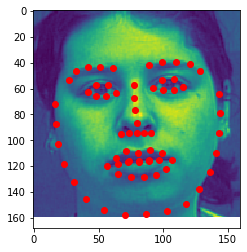

In [31]:
plt.imshow(images[1].getImage())
view_landmarks(images[1].getLandmarks())

In [32]:
numImages = len(images)

avgLandmarks = (images[0].getLandmarks() / numImages)

for image in images[1:]:
    avgLandmarks += (image.getLandmarks()) / numImages

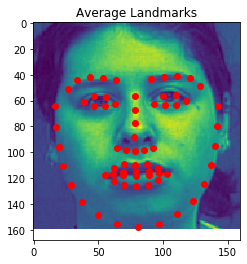

In [33]:
plt.imshow(images[0].getImage())
plt.title("Average Landmarks")
view_landmarks(avgLandmarks)

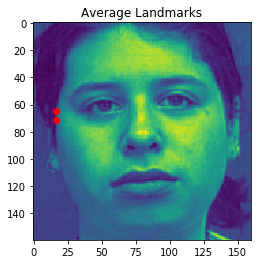

In [34]:
plt.imshow(images[0].getImage())
plt.title("Average Landmarks")
view_landmarks(avgLandmarks[:1])
view_landmarks(images[0].getLandmarks()[:1])

In [35]:
def appendLastRowAsCol(npMatrix):
    return np.c_[npMatrix[:-1,:].T, np.array([npMatrix[-1,:]]).T ]

In [36]:
def pairPlot(im1, im2, clear_figure=False, title=''):
    if not clear_figure:
        plt.figure()
    
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(im1)
    axes[1].imshow(im2)

    fig.suptitle(title, fontsize=16)
    
def getTrianglePts(triangle_points_array):
    return (tuple(triangle_points_array[0:2].astype(np.int32)), tuple(triangle_points_array[2:4].astype(np.int32)), tuple(triangle_points_array[4:6].astype(np.int32)))

def getTriangleImage(im, triangle_points_array):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    triangle = np.array([pt1, pt2, pt3])
    
    triangle_im = im
    triangle_mask = np.zeros_like(im)

    triangle_mask_fill_points = np.array([
            [pt1[0], pt1[1]],
            [pt2[0], pt2[1]],
            [pt3[0], pt3[1]]
        ], np.int32)
    cv2.fillConvexPoly(triangle_mask, triangle_mask_fill_points, (255,255,255))
        
    cropped_triangle = cv2.bitwise_and(triangle_mask, triangle_im)
    return cropped_triangle

def drawTriangle(im, triangle_points_array, color):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    
    cv2.line(im, pt1, pt2, color, 2)
    cv2.line(im, pt1, pt3, color, 2)
    cv2.line(im, pt3, pt2, color, 2)

def draw_delaunay(im, subdiv_triangles, color):

    for t in subdiv_triangles:
        drawTriangle(im, t, color)

def get_second_delaunay_triangles(im, src_triangles, src_landmarks, dest_landmarks):
    src_landmarks = np.array(src_landmarks).astype(np.float32)

    dest_triangles = np.array([[1,2,3,4,5,6]])
    for t in src_triangles:
        pt1 = np.array([t[0], t[1]])
        pt2 = np.array([t[2], t[3]])
        pt3 = np.array([t[4], t[5]])
  
        index_pt1 = np.where((pt1 == src_landmarks).all(axis=1))[0][0]
        index_pt2 = np.where((pt2 == src_landmarks).all(axis=1))[0][0]
        index_pt3 = np.where((pt3 == src_landmarks).all(axis=1))[0][0]

        dest_triangle = np.array([dest_landmarks[index_pt1], dest_landmarks[index_pt2], dest_landmarks[index_pt3]]).flatten()
        dest_triangles = np.concatenate((dest_triangles, np.array([dest_triangle])), axis=0)
    
    return dest_triangles[1:]

In [37]:
DRAW_EXAMPLE = False

dest = list(map(lambda x: tuple(x),avgLandmarks))

with tqdm(total=len(images), desc="Neutralizing emotions") as pbar:

    for image in images[:]:
        src = list(map(lambda x: tuple(x),image.getLandmarks()))

        image.clearImage()
        im = image.getImage()
        im_shape = im.shape

        rect = (0,0,im_shape[1],im_shape[0])
        subdiv = cv2.Subdiv2D(rect)
        
        try:
            subdiv.insert(src)
        except:
            pbar.update(1)
            continue
            
        src_triangles = subdiv.getTriangleList()

        dest_triangles = get_second_delaunay_triangles(im, src_triangles, src, dest)

        warped_image = np.zeros_like(im)      
        for (src_triangle, dest_triangle) in zip(src_triangles, dest_triangles):
            ## Change this code
            src_triangle = src_triangle.reshape(3,2).astype(np.float32)
            dest_triangle = dest_triangle.reshape(3,2).astype(np.float32)

            M = cv2.getAffineTransform(src_triangle, dest_triangle)

            src_triangle_image = getTriangleImage(im, src_triangle.flatten())

            dest_boundingRect = cv2.boundingRect(dest_triangle)
            (dx, dy, dw, dh) = dest_boundingRect

            warped_image_triangle = cv2.warpAffine(src_triangle_image, M,  src_triangle_image.shape)

            warped_triangle_area = warped_image[dy: dy + dh, dx : dx + dw]        
            warped_triangle_area = cv2.add(warped_triangle_area, warped_image_triangle[dy: dy + dh, dx : dx + dw])

            warped_image[dy: dy + dh, dx : dx + dw] = warped_triangle_area

        image.setNeutralisedImage(warped_image)
        pbar.update(1)

        if DRAW_EXAMPLE:
            print("DRAW_EXAMPLE IS TRUE")
            pairPlot(warped_image,im )
            break

Neutralizing emotions: 100%|███████████████████████████████████████████████████████| 3708/3708 [01:11<00:00, 51.86it/s]


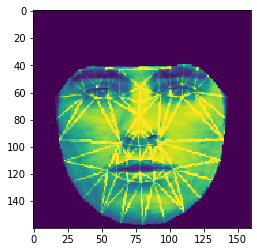

In [38]:
plt.imshow(images[257].getNeutralisedImage())

In [39]:
images[0].getName()

'..\\Data\\CK+\\cohn-kanade-images\\S111\\002\\S111_002_00000001.png'

In [40]:
import os
from PIL import Image

with tqdm(total=len(images), desc="Saving Neutralized emotions") as pbar:

    for image in images:

        path = "NeutralisedImages" + image.getName().split("Data")[-1]
        directory = "\\".join(path.split("\\")[:-1])

        if not os.path.exists(directory):
            os.makedirs(directory)

        try:
            im = Image.fromarray(image.getNeutralisedImage())
            im.save(path)
            pbar.update(1)
        except:
            
            pbar.update(1)
            continue


Saving Neutralized emotions: 100%|████████████████████████████████████████████████| 3708/3708 [00:04<00:00, 745.04it/s]


In [42]:
neutralized_image_files = glob.glob('NeutralisedImages\\CK+\\cohn-kanade-images/**/*.png', recursive=True)
neutralized_image_files[:5]

['NeutralisedImages\\CK+\\cohn-kanade-images\\S111\\002\\S111_002_00000001.png',
 'NeutralisedImages\\CK+\\cohn-kanade-images\\S111\\002\\S111_002_00000002.png',
 'NeutralisedImages\\CK+\\cohn-kanade-images\\S111\\002\\S111_002_00000003.png',
 'NeutralisedImages\\CK+\\cohn-kanade-images\\S111\\002\\S111_002_00000004.png',
 'NeutralisedImages\\CK+\\cohn-kanade-images\\S111\\002\\S111_002_00000005.png']

In [45]:
neutralized_image_files[1].split('\\')[3]

'S111'

In [46]:
def detect_face(f,required_size=(160, 160)):
    ''' function to detect face, crop the image and resize it '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    
    image = Image.fromarray(gray)
    image = image.resize(required_size)
    image = image.convert('RGB')
    face_array = np.asarray(image)
    return face_array

In [47]:
faces_ck = list()
labels_ck  = list()
tmp_lab_prev = ''
tmp_lab = ''
for i in tqdm(range(len(neutralized_image_files))):
    i_im = neutralized_image_files[i]
    tmp_lab = i_im.split('\\')[3]
    '''if(tmp_lab != tmp_lab_prev):
        print('Started pre-processing with subject:'+ tmp_lab)
    '''
    face = detect_face(i_im)
    
     
    labels_ck.append(tmp_lab)
    
    # store
    faces_ck.append(face)
    tmp_lab_prev = tmp_lab
    

100%|████████████████████████████████████████████████████████████████████████████| 3708/3708 [00:02<00:00, 1757.42it/s]


In [48]:
X_full_ck = np.asarray(faces_ck)

In [49]:
l_full_ck = np.asarray(labels_ck)

In [52]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X_full_ck, l_full_ck, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2966, 160, 160, 3), (742, 160, 160, 3), (2966,), (742,))

In [53]:
# save arrays to one file in compressed format
np.savez_compressed('ck+dataset-neutralized.npz', X_train, y_train, X_test, y_test)

In [54]:
# load the face dataset
data = np.load('ck+dataset-neutralized.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (2966, 160, 160, 3) (2966,) (742, 160, 160, 3) (742,)


# Load pre-trained FaceNET model

In [58]:
model = load_model('..\\Data\\Model\\model\\facenet_keras.h5')

In [59]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1_2:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_2/cond/Merge:0' shape=(?, 128) dtype=float32>]


# Use FaceNet to generate embeddings for each image

In [60]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [61]:
# convert each face in the train set to an embedding
newTrainX = list()
for i in tqdm(range(trainX.shape[0])):
    face_pixels = trainX[i]
    embedding = get_embedding(model, face_pixels)
    '''if((i+1)% 100 == 0):
        print("Processed " + str(i+1) + " faces")
        '''
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 2966/2966 [04:48<00:00, 10.29it/s]


(2966, 128)


In [62]:
# convert each face in the test set to an embedding
newTestX = list()
for i in tqdm(range(testX.shape[0])):
    face_pixels = testX[i]
    embedding = get_embedding(model, face_pixels)
    '''if((i+1)% 100 == 0):
        print("Processed " + str(i+1) + " faces")
    '''
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 742/742 [01:09<00:00, 10.74it/s]


(742, 128)


In [63]:
# save arrays to one file in compressed format
np.savez_compressed('ck+-faces-embeddings-neutralized.npz', newTrainX, trainy, newTestX, testy)

In [64]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

In [65]:
# load faces
data = load('ck+dataset-neutralized.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('ck+-faces-embeddings-neutralized.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model_SVM = SVC(kernel='linear', probability=True)
model_SVM.fit(trainX, trainy)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [68]:
# prediction vector for the test set
yhat_accuracy = model_SVM.score(testX, testy)
print("Accuracy on test set = "+str(yhat_accuracy*100) + "%")

Accuracy on test set = 100.0%


412
Predicted: S999 (57.905)
Expected: S999


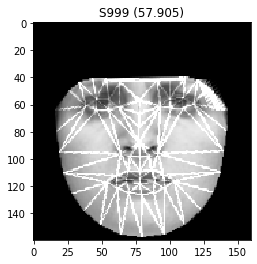

16
Predicted: S113 (69.746)
Expected: S113


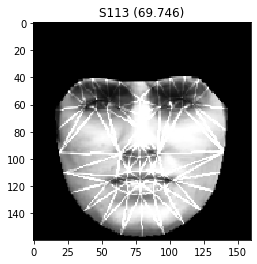

436
Predicted: S114 (90.461)
Expected: S114


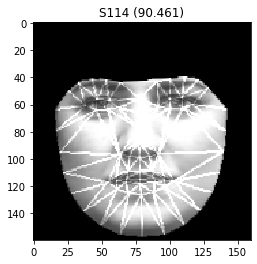

323
Predicted: S118 (75.239)
Expected: S118


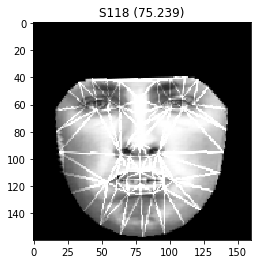

604
Predicted: S122 (76.223)
Expected: S122


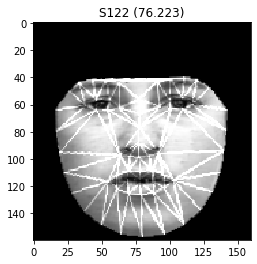

435
Predicted: S136 (81.224)
Expected: S136


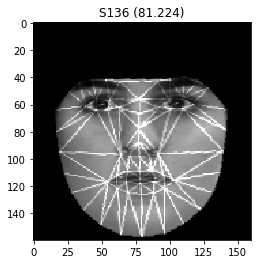

175
Predicted: S130 (91.631)
Expected: S130


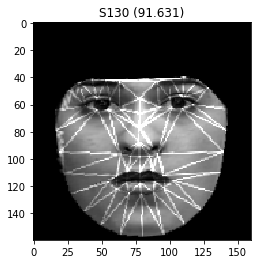

682
Predicted: S117 (84.425)
Expected: S117


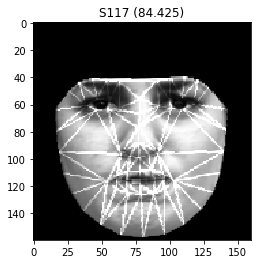

345
Predicted: S506 (83.649)
Expected: S506


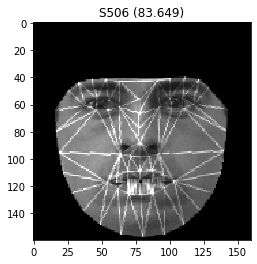

403
Predicted: S127 (90.692)
Expected: S127


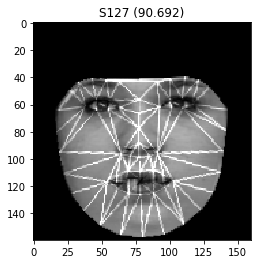

666
Predicted: S113 (83.809)
Expected: S113


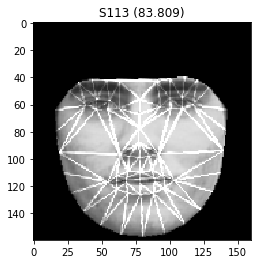

95
Predicted: S126 (80.364)
Expected: S126


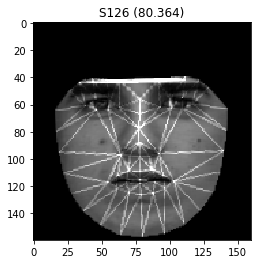

102
Predicted: S139 (31.044)
Expected: S139


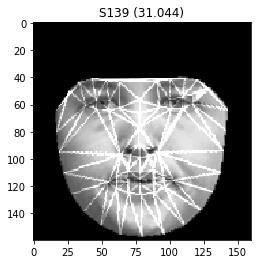

29
Predicted: S132 (91.402)
Expected: S132


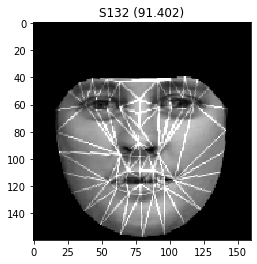

504
Predicted: S124 (79.138)
Expected: S124


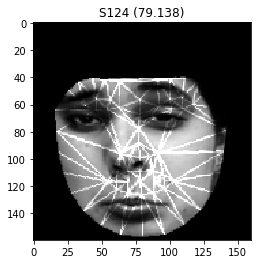

439
Predicted: S119 (76.482)
Expected: S119


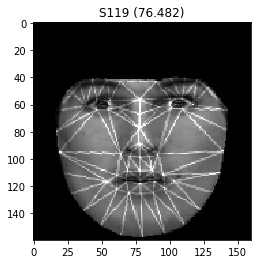

249
Predicted: S124 (88.939)
Expected: S124


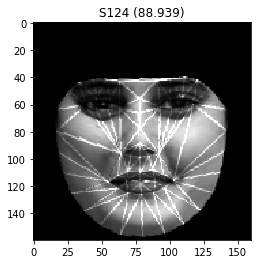

156
Predicted: S113 (76.136)
Expected: S113


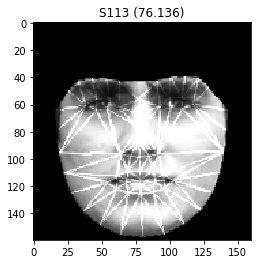

341
Predicted: S111 (84.640)
Expected: S111


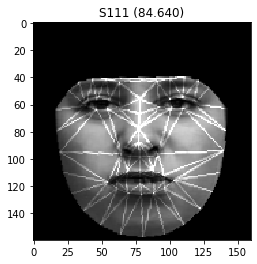

45
Predicted: S115 (91.362)
Expected: S115


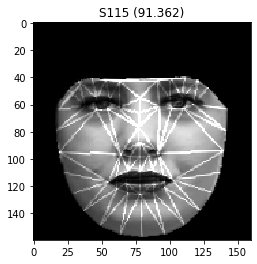

286
Predicted: S113 (90.957)
Expected: S113


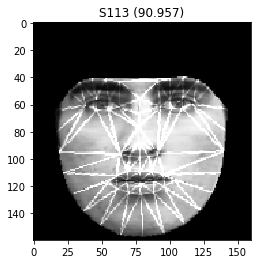

329
Predicted: S117 (88.316)
Expected: S117


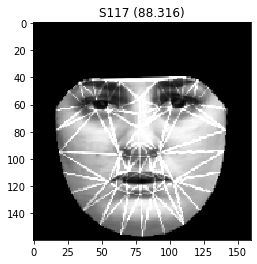

472
Predicted: S506 (85.926)
Expected: S506


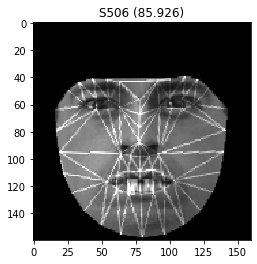

463
Predicted: S113 (84.743)
Expected: S113


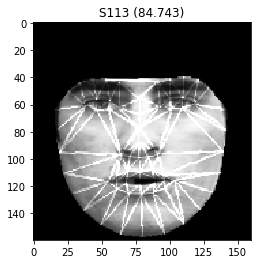

680
Predicted: S133 (92.688)
Expected: S133


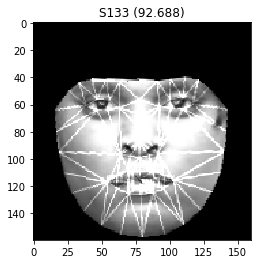

190
Predicted: S124 (93.374)
Expected: S124


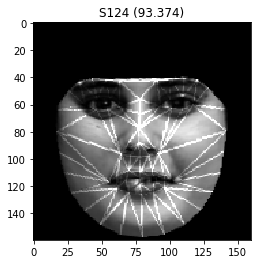

430
Predicted: S126 (90.369)
Expected: S126


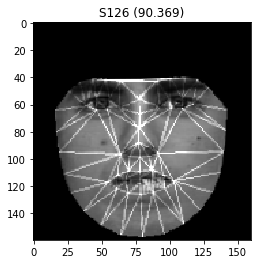

228
Predicted: S502 (62.739)
Expected: S502


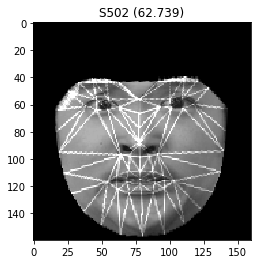

139
Predicted: S504 (75.774)
Expected: S504


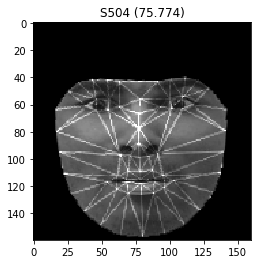

53
Predicted: S115 (80.337)
Expected: S115


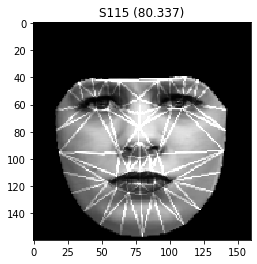

95
Predicted: S126 (80.364)
Expected: S126


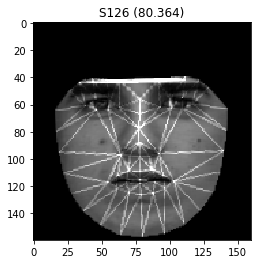

732
Predicted: S113 (78.364)
Expected: S113


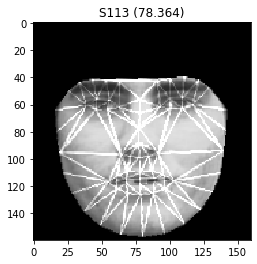

590
Predicted: S136 (61.594)
Expected: S136


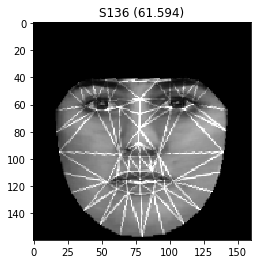

731
Predicted: S133 (90.704)
Expected: S133


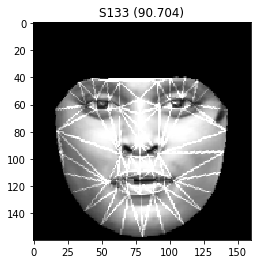

111
Predicted: S112 (77.442)
Expected: S112


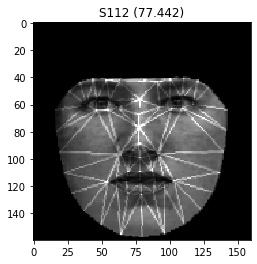

275
Predicted: S506 (53.873)
Expected: S506


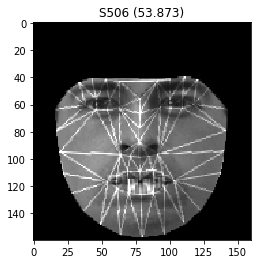

497
Predicted: S126 (67.936)
Expected: S126


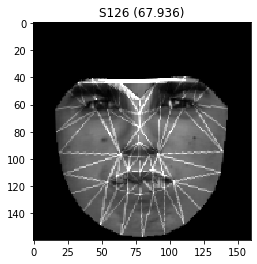

87
Predicted: S129 (87.540)
Expected: S129


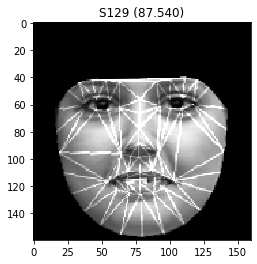

244
Predicted: S506 (79.135)
Expected: S506


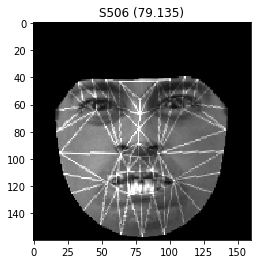

193
Predicted: S502 (73.336)
Expected: S502


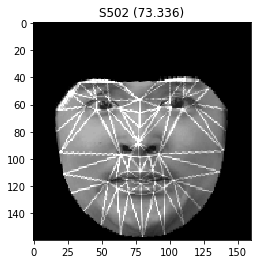

461
Predicted: S138 (88.100)
Expected: S138


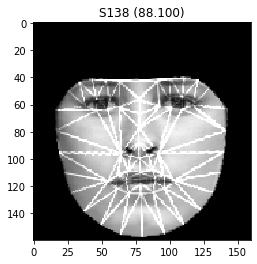

408
Predicted: S124 (92.901)
Expected: S124


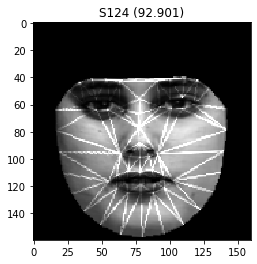

363
Predicted: S503 (75.422)
Expected: S503


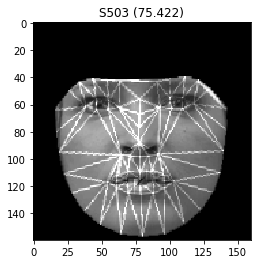

570
Predicted: S503 (79.707)
Expected: S503


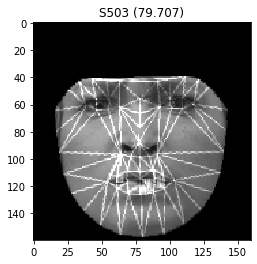

166
Predicted: S130 (96.445)
Expected: S130


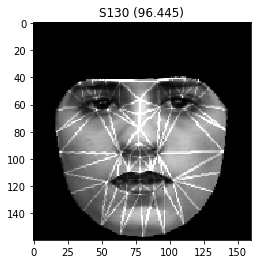

614
Predicted: S122 (78.059)
Expected: S122


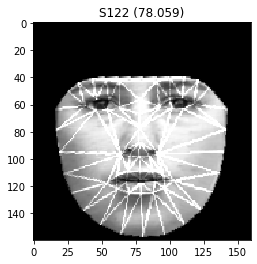

494
Predicted: S502 (71.947)
Expected: S502


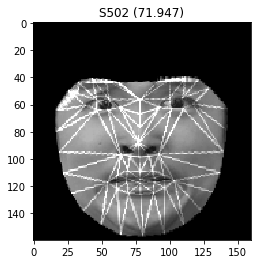

727
Predicted: S999 (65.383)
Expected: S999


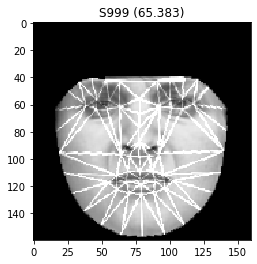

178
Predicted: S127 (94.226)
Expected: S127


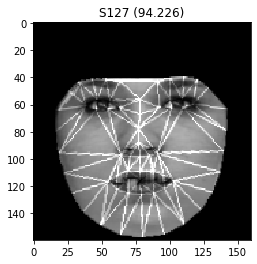

117
Predicted: S111 (77.123)
Expected: S111


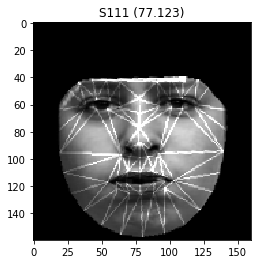

176
Predicted: S506 (75.767)
Expected: S506


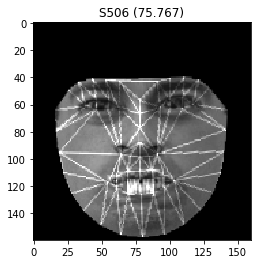

469
Predicted: S126 (84.685)
Expected: S126


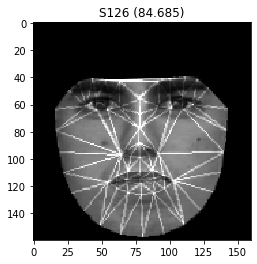

139
Predicted: S504 (75.774)
Expected: S504


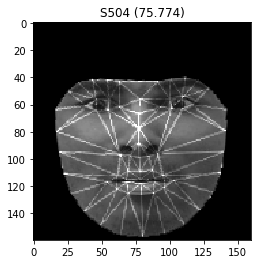

45
Predicted: S115 (91.362)
Expected: S115


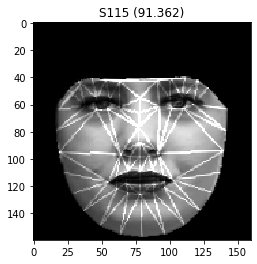

62
Predicted: S506 (88.579)
Expected: S506


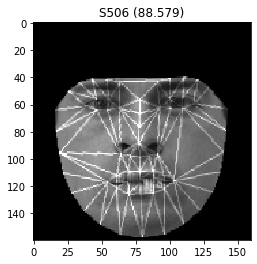

97
Predicted: S122 (83.042)
Expected: S122


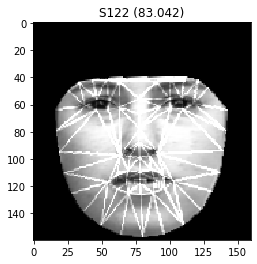

381
Predicted: S135 (77.256)
Expected: S135


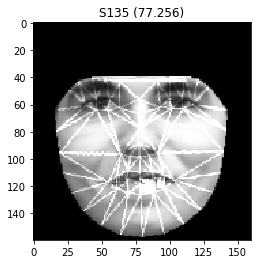

629
Predicted: S125 (92.492)
Expected: S125


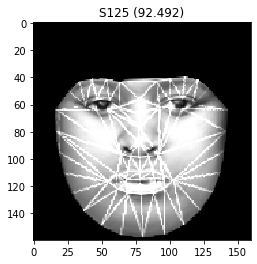

301
Predicted: S121 (68.671)
Expected: S121


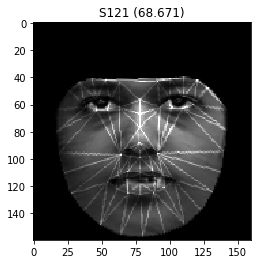

583
Predicted: S129 (87.258)
Expected: S129


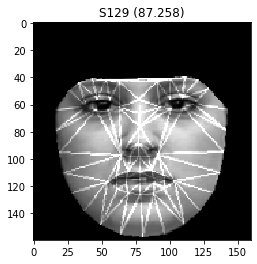

51
Predicted: S126 (78.020)
Expected: S126


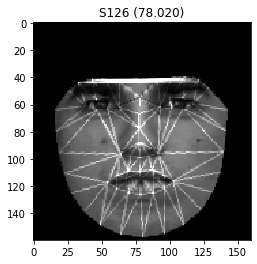

423
Predicted: S137 (75.717)
Expected: S137


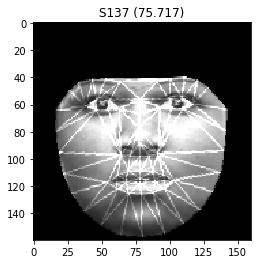

45
Predicted: S115 (91.362)
Expected: S115


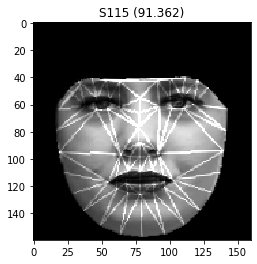

737
Predicted: S130 (90.920)
Expected: S130


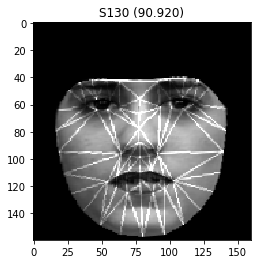

472
Predicted: S506 (85.926)
Expected: S506


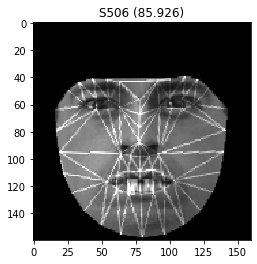

531
Predicted: S127 (86.622)
Expected: S127


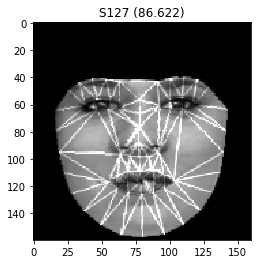

71
Predicted: S127 (85.412)
Expected: S127


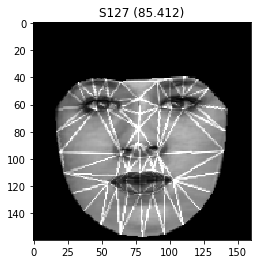

63
Predicted: S135 (90.519)
Expected: S135


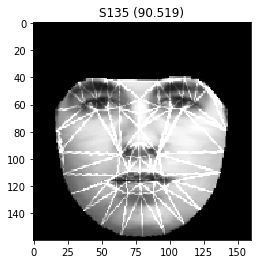

137
Predicted: S118 (82.817)
Expected: S118


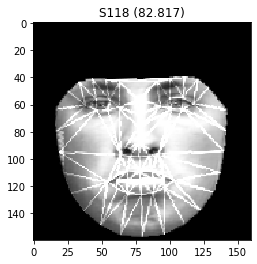

625
Predicted: S506 (86.934)
Expected: S506


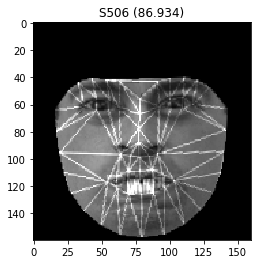

641
Predicted: S502 (78.942)
Expected: S502


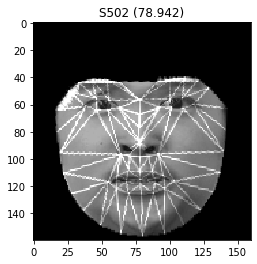

388
Predicted: S132 (81.019)
Expected: S132


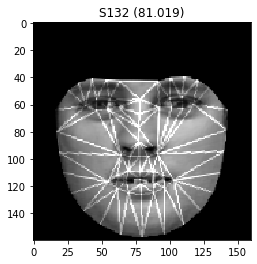

194
Predicted: S113 (90.448)
Expected: S113


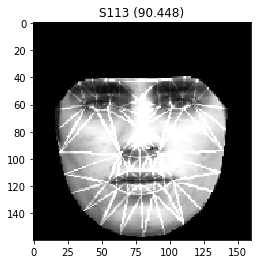

681
Predicted: S115 (92.691)
Expected: S115


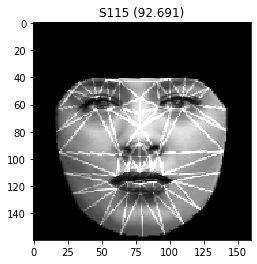

397
Predicted: S115 (90.460)
Expected: S115


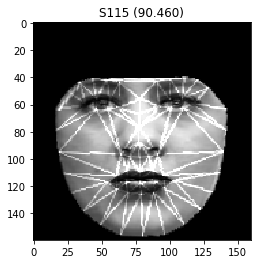

219
Predicted: S119 (88.499)
Expected: S119


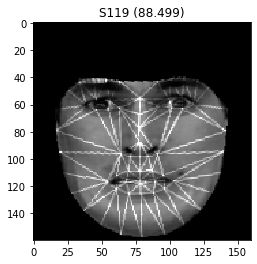

583
Predicted: S129 (87.258)
Expected: S129


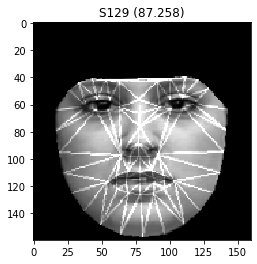

114
Predicted: S126 (83.165)
Expected: S126


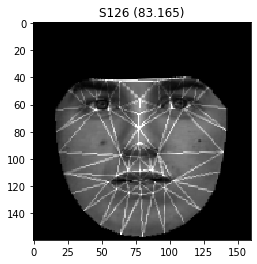

485
Predicted: S132 (93.184)
Expected: S132


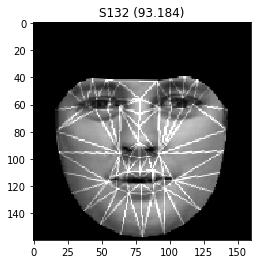

625
Predicted: S506 (86.934)
Expected: S506


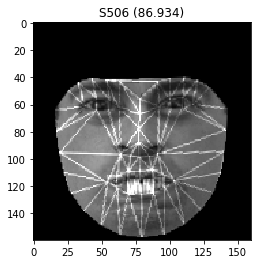

527
Predicted: S119 (85.243)
Expected: S119


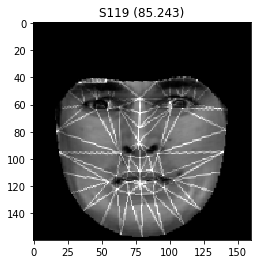

13
Predicted: S502 (54.836)
Expected: S502


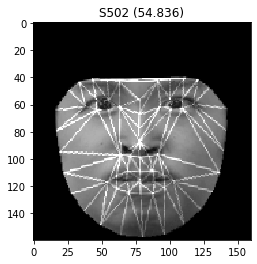

233
Predicted: S127 (86.157)
Expected: S127


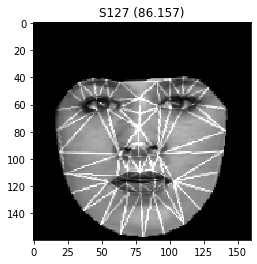

313
Predicted: S130 (94.393)
Expected: S130


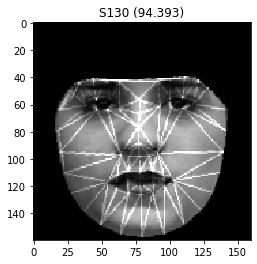

696
Predicted: S113 (94.109)
Expected: S113


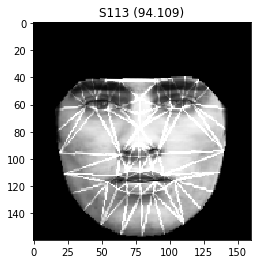

241
Predicted: S132 (82.999)
Expected: S132


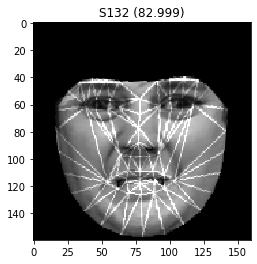

424
Predicted: S131 (88.049)
Expected: S131


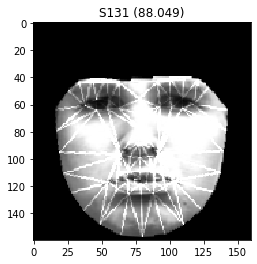

449
Predicted: S113 (77.630)
Expected: S113


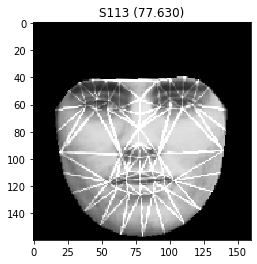

513
Predicted: S506 (83.696)
Expected: S506


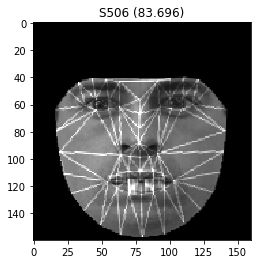

589
Predicted: S502 (82.561)
Expected: S502


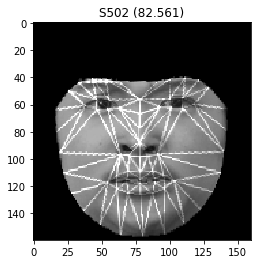

240
Predicted: S134 (83.518)
Expected: S134


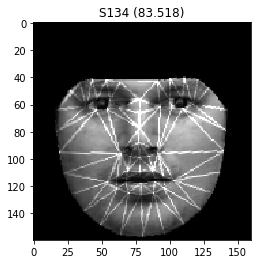

735
Predicted: S119 (91.255)
Expected: S119


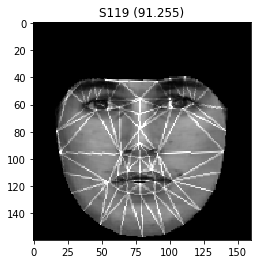

79
Predicted: S124 (70.945)
Expected: S124


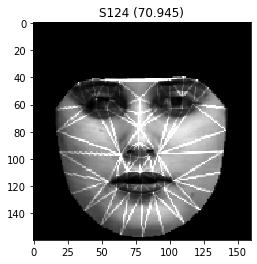

186
Predicted: S131 (91.672)
Expected: S131


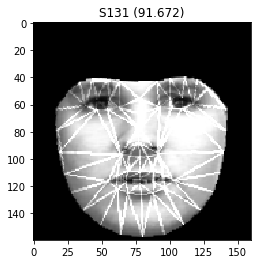

621
Predicted: S113 (86.904)
Expected: S113


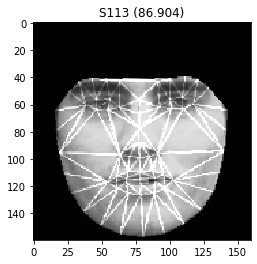

496
Predicted: S133 (95.167)
Expected: S133


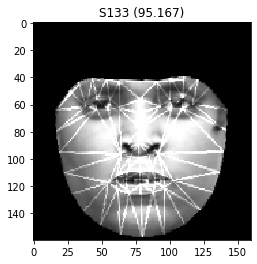

133
Predicted: S124 (92.184)
Expected: S124


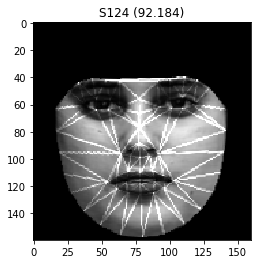

274
Predicted: S501 (92.970)
Expected: S501


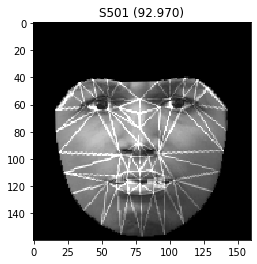

697
Predicted: S129 (84.362)
Expected: S129


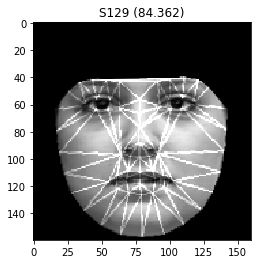

642
Predicted: S111 (40.510)
Expected: S111


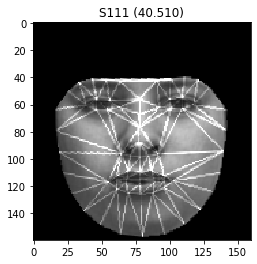

In [69]:
num_runs = 100
for ind in range(num_runs):
    # test model on a random example from the test dataset
    selection = choice([i for i in range(testX.shape[0])])
    print(selection)
    random_face_pixels = testX_faces[selection]
    random_face_emb = testX[selection]
    random_face_class = testy[selection]
    random_face_name = out_encoder.inverse_transform([random_face_class])
    # prediction for the face
    samples = expand_dims(random_face_emb, axis=0)
    yhat_class = model_SVM.predict(samples)
    yhat_prob = model_SVM.predict_proba(samples)
    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)
    print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
    print('Expected: %s' % random_face_name[0])
    # plot for fun
    pyplot.imshow(random_face_pixels)
    title = '%s (%.3f)' % (predict_names[0], class_probability)
    pyplot.title(title)
    pyplot.show()